# Google Scholar Trend Crawling
This code is a cleaned up version of `1. Scholar_Scraping.ipynb`. You may find extra comments there


## *Google Scholar Parser Check List*
<input type="checkbox" checked> Parse proxy list \
<input type="checkbox" checked> Avoid google detection and CAPTCHA page dynamically \
<input type="checkbox" checked>  Fix citations with different languages since they depend on proxy location \
<input type="checkbox" checked > Source links are more than expected at times - this screws up the "Source" column, so be careful about it \
(<input type="checkbox" checked >) Use multi-threading / multi-processing to speed up the huge for loop ~~(currently it takes >4 hours)~~ with this less than 30 minutes! \
<input type="checkbox" checked> Use shared dataframe to improve proxy checking stats and efficiency (does not work in the `multiprocessing` part) \
<input type="checkbox" > Years is sometimes 0 if the publisher contains a "-" (e.g. diva-portal.org) \
<input type="checkbox" > If the word has some problems, such as "Hemocopatible coating" (in this case a misspelling) and Google suggests another one, then the code fucks it up -> either check always that words are correct, or we should make some extra code for fixing this \
<input type="checkbox" checked > Create keyword database and save them in folders for each team

In [ ]:
import sys
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from tqdm.notebook import tqdm # notebook version, a bit cooler
from warnings import warn
import multiprocessing # speed up the crawler
from tabulate import tabulate # fancify some stuff
import re

## Create proxies dataframe

In [ ]:
# Get free proxies
url = "https://raw.githubusercontent.com/monosans/proxy-list/main/proxies_geolocation/http.txt" 
proxies_raw = pd.read_csv(url,  sep="::", names=["Address:port", "Country", "Region", "City"])

# Modify the dataset
# let's remove Chinese servers (CCP blocks access to Scholar too, lol)
proxies = proxies_raw[proxies_raw['Country'] != 'China']
proxies = proxies.assign(Success=0, Blocked=0, Timeout=0) # add extra metrics to the dataframe to get the best server
proxies.reset_index(drop=True, inplace=True)
proxies

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Address:port,Country,Region,City,Success,Blocked,Timeout
0,1.1.220.100:8080,Thailand,Lampang,Lampang,0,0,0
1,1.2.252.65:8080,Thailand,Phichit,Phichit,0,0,0
2,1.10.189.156:32078,Thailand,Bangkok,Bangkok,0,0,0
3,1.53.50.251:9999,Vietnam,Ho Chi Minh,Ho Chi Minh City,0,0,0
4,1.186.40.9:54754,India,Maharashtra,Mumbai,0,0,0
...,...,...,...,...,...,...,...
1036,221.120.210.220:39617,Pakistan,Punjab,Faisalabad,0,0,0
1037,222.165.235.2:80,Indonesia,Jakarta,Jakarta,0,0,0
1038,222.165.235.254:80,Indonesia,Jakarta,Jakarta,0,0,0
1039,222.252.23.5:8080,Vietnam,Hanoi,Hanoi,0,0,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Address:port,Country,Region,City,Success,Blocked,Timeout
0,1.1.189.58:8080,Thailand,Yasothon,Yasothon,0,0,0
1,1.2.252.65:8080,Thailand,Phichit,Phichit,0,0,0
2,1.4.157.35:46944,Thailand,Songkhla,Songkhla,0,0,0
3,1.10.187.237:8080,Thailand,Bangkok,Bangkok,0,0,0
4,1.10.189.156:32078,Thailand,Bangkok,Bangkok,0,0,0
...,...,...,...,...,...,...,...
1850,220.87.222.238:8118,Japan,Tokyo,Tokyo,0,0,0
1851,222.124.193.113:8080,Indonesia,West Java,Bandung,0,0,0
1852,222.165.194.67:58687,Indonesia,West Java,Bandung,0,0,0
1853,222.165.221.12:58687,Indonesia,West Java,Bandung,0,0,0


## Proxy utils

In [ ]:
# Anti-detection utils

timeout = 10 # proxy timeout
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36, 'referer':'https://www.google.com/'}"}

# Function to order proxy reliability
def move_row(df, idx, to='first'):
  """Move dataframe row. Rough implementation, maybe there is a cleaner way
  but this seems to get the job done
  Args:
    df: dataframe
    idx: index of the row
    to: position, either 'first' or 'last'
  """
  size = len(df)
  if idx >= size-1:
    return df # cannot move this one
  else:
    reindexing = np.arange(size)
    if to is 'first':
      reindexing[:idx+1] -= 1
      reindexing[0] = idx
    elif to is 'last':
      reindexing[idx:] += 1
      reindexing[size-1] = idx
    else:
      warn(f'Keyword {to} has no effect for now')
      return df # cannot move this one
    df = df.reindex(reindexing)
    df.reset_index(drop=True, inplace=True)
  return df

# Captcha detection
def detect_captcha(soup):
  """Detect if the webpage (Google in this case) is asking for the Captcha code"""
  # captcha = soup.find("form", id="gs_captcha_f")
  captcha = soup.select('form[id*="captcha"]') # this should recognize every form containing captcha
  if captcha:
    return True
  else:
    return False

# Randomize time with a uniform distribution, we should adjust the times depending on the detection rate
def random_time(low=0.6, high=3.0):
  return np.random.uniform(low=low, high=high, size=None)

# Obtain webpage with some tricks
def proxy_get(url):
  """Iterate over proxy dataframe to obtain a valid webpage
  The function does the following:
    - Check for working pages
    - Check for captcha
    - Change non-working proxies position so they aren't checked again
    - Random sleep to avoid re-detection with same proxy
    - Metrics saving
  Args:
    url: url to search for in string format
    proxies: pandas dataframe containing the proxies

  NOTE: still a rough implementation, some stuff is subject to change. Feedback is welcome :)
  """
  global proxies
  for index, proxy_row in proxies.iterrows():
    proxy = {'https':'https://'+str(proxy_row['Address:port'])}
    try:
      page = session.get(url, proxies=proxy, headers=headers, timeout=timeout) # use proxy to avoid detection
    except:
      # Timeout proxy becomes last in the dataframe, so we don't retry it
      proxies.loc[index, 'Timeout'] += 1 # increase timeouts number
      proxies = move_row(proxies, index, to='last')
      continue
    else:
      c = page.content
      soup = BeautifulSoup(c, 'html.parser') # parser
      if detect_captcha(soup):
        # Proxy with CAPTCHA verification becomes last in the dataframe, so we don't retry it
        proxies.loc[index, 'Blocked'] += 1 # increase blocked number
        proxies = move_row(proxies, index, to='last')
        continue
      else:
        proxies.loc[index, 'Success'] += 1 # increase success number
        break

  # Randomize time between requests
  time.sleep(random_time())
  return soup

## Scholar utilities

In [ ]:
def get_citations(content):
    """Parse content with "/scholar?cites, so it works in multiple languages"""
    try:
      item = content.find_all("a", href=lambda href: href and href.startswith("/scholar?cites"))[0]
      if hasattr(item, 'string'):
        # Needed for e.g. Thai language in which there is no space or Chinese in which the counter 次 screws up the count
        citations = item.string.replace(" ", "") 
        citations = int(re.findall(r"\d+", citations)[0])
    except:
      citations = 0 # if citations could not be parsed this is the default return value
    return citations

def get_year(content):
    for char in range(0,len(content)):
      if content[char] == '-':
        out = content[char-5:char-1]
    if not out.isdigit():
        out = 0
    return int(out)

def get_author(content):
    for char in range(0,len(content)):
        if content[char] == '-':
            out = content[2:char-1]
            break
    return out

## Single Keyword Test

In [ ]:
# Start new session

keyword = '광 조사'
session = requests.Session()
path = './'+keyword+'_result_cgbio.csv' # path to save the data
number_of_results = 100
save_database = True

links = list()
title = list()
citations = list()
year = list()
rank = list()
author = list()
rank.append(0) # initialization necessary for incremental purposes

for n in tqdm(range(0, number_of_results, 10)):    
    url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
    soup = proxy_get(url)

    # Get stuff
    mydivs = soup.findAll("div", { "class" : "gs_r" })
    
    for div in mydivs:
        try:
            links.append(div.find('h3').find('a').get('href'))
        except Exception as e: # catch *all* exceptions
            # If the above fails, we should not append anything or we introduce dummy variables
            # links.append('no link')
            continue 
        try:
            title.append(div.find('h3').find('a').text)
        except: 
            title.append('Could not catch title')
        try:
          year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
        except:
          year.append(0)
        try:
          author.append(get_author(div.find('div',{'class' : 'gs_a'}).text))
        except:
          author.append('Could not catch author')
        citations.append(get_citations(div))
        rank.append(rank[-1]+1)

print(len(links), len(title), len(citations), len(year), len(author))

  0%|          | 0/10 [00:00<?, ?it/s]

95 95 95 95 95


  0%|          | 0/10 [00:00<?, ?it/s]

95 95 95 95 95


                                     Author  ...                                             Source
Rank                                         ...                                                   
19                희， 조애， 오영희， 변용찬， 변재관， 문현상  ...  http://repository.kihasa.re.kr/bitstream/20100...
82                                     Park  ...  https://www.koreascience.or.kr/article/JAKO200...
36     Lee, SS Oh, SH Cha, YA Jang, SY Kim…  ...  https://www.koreascience.or.kr/article/JAKO201...
24            희， 김은설， 최진， 안재진， 최혜선， 김유경， 조애  ...  http://repo.kicce.re.kr/bitstream/2019.oak/136...
50               Um, SS Oh, JG Lee, SY Kim…  ...  https://www.koreascience.or.kr/article/JAKO201...
...                                     ...  ...                                                ...
22                  시미츄히로， 카이호나오키， 타케야노리요시…  ...            http://ir.opt.ac.cn/handle/181661/33797
59                              섭， 김종수， 이진국  ...  https://www.cheric.org/research/tech/periodica...


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44305 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text

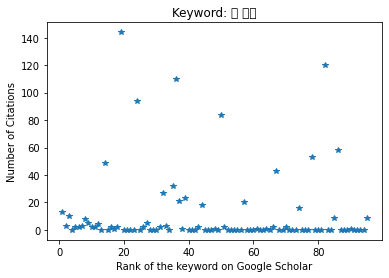

                                     Author  ...                                             Source
Rank                                         ...                                                   
19                희， 조애， 오영희， 변용찬， 변재관， 문현상  ...  http://repository.kihasa.re.kr/bitstream/20100...
82                                     Park  ...  https://www.koreascience.or.kr/article/JAKO200...
36     Lee, SS Oh, SH Cha, YA Jang, SY Kim…  ...  https://www.koreascience.or.kr/article/JAKO201...
24            희， 김은설， 최진， 안재진， 최혜선， 김유경， 조애  ...  http://repo.kicce.re.kr/bitstream/2019.oak/136...
50               Um, SS Oh, JG Lee, SY Kim…  ...  https://www.koreascience.or.kr/article/JAKO201...
...                                     ...  ...                                                ...
22                  시미츄히로， 카이호나오키， 타케야노리요시…  ...            http://ir.opt.ac.cn/handle/181661/33797
59                              섭， 김종수， 이진국  ...  https://www.cheric.org/research/tech/periodica...


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44305 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text

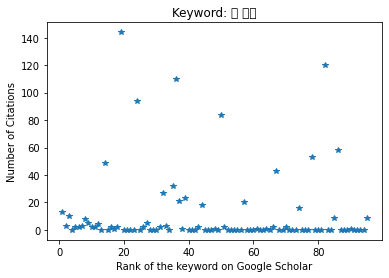

In [ ]:
# Create a dataset and sort by the number of citations
data = pd.DataFrame(zip(author, title, citations, year, links), index = rank[1:], 
                    columns=['Author', 'Title', 'Citations', 'Year', 'Source'])
data.index.name = 'Rank'

data_ranked = data.sort_values('Citations', ascending=False)
print(data_ranked)

# Plot by citation number
plt.plot(rank[1:],citations,'*')
plt.ylabel('Number of Citations')
plt.xlabel('Rank of the keyword on Google Scholar')
plt.title('Keyword: '+keyword)

# Save results
if save_database:
    data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path

## Create keywords dataframe


In [ ]:
# Keywords dataframe
# Note: do NOT insert special characters such as "/" otherwise the progam may crash
keywords = pd.DataFrame(columns=['Research Team', 'Technical Keywords', 'Product Keywords', 'ETC'])
for i in range(10):
  keywords = keywords.append({'Research Team': 'Team ' + str(i+1)}, ignore_index=True)
keywords.set_index('Research Team', inplace=True, drop=True)
keywords['Technical Keywords']['Team 1'] = ['연골재생','TGF beta-3', 'BMP-2', '생체재료', '의료기기', '골재생']
keywords['Product Keywords']['Team 1']   = ['골이식재', '연골대체재', '연골활액', '치과용', '이식재']
keywords['Technical Keywords']['Team 2'] = ['유착방지제', '지혈제', '드레싱제', '점착성투명창상피복재', '콜라겐']
keywords['Product Keywords']['Team 2']   = ['온도감응', '혈액응고', '가피', '흉터','주름 개선','세포, 진피','(연)조직 재생']
keywords['ETC']['Team 2']                = ['차세대', '신규', '혁신', '차별', '경쟁력', '가성비', '재생', '의료기기']
keywords['Technical Keywords']['Team 3'] = ['광 조사' , '맞춤형 피부 케어', 'EGF' , 'NPWT(음압상처치료)','혈액 튜브', '박동형 펌프', '항응고 코팅', '욕창 예방 시스템', '원심분리', '음압 마사지']
keywords['Product Keywords']['Team 3']   = ['의료용흡인기', '광선조사기', '조합자극기', '가슴체적측정기', '체외막심폐순환보조장치', '골수처리기구', '창상피복재']
keywords['Technical Keywords']['Team 4'] = ['spine', 'spinal implant', 'spinal fusion device surface treatment', 'hydrophilic', 'spinal technology', 'technologies', '3D printing', 'navigation', 'innovative', 'innovation', 'platform', 'development', 'digital surgery', 'guide', 'image guided', 'robotic guided']
keywords['Product Keywords']['Team 4']   = ['Expandable cage', '3D printing cage', 'VBR', 'vertebral body replacement', 'ADR', 'artificial disc replacement', 'TDR', 'total disc replacement', 'joint replacement', 'MIS', 'minimal invasive surgery', 'percutaneous', 'pedicle screw', 'pediatric screw', 'deformity surgery', 'cervical screw', 'occipital plate', 'ACP', 'anterior cervical plate', 'translation plate']
keywords['Technical Keywords']['Team 5'] = ['형상기억합금', '레이저 가공', '전해연마', '화학연마', '혈관 재생', '기계적 혈전 제거술', '코일 색전술', '전기 절제 도자술']
keywords['Product Keywords']['Team 5']   = ['뇌혈관용 스텐트', '전극카테터', '색전 제거 스텐트', '마이크로카테터', '풍선카테터', '소화기', '스텐트']
keywords['ETC']['Team 5']                = ['뇌혈관 중재시술 의료기기', '소화기 질환 치료 의료기기', '혈관 재생 의료기기']
keywords['Technical Keywords']['Team 6'] = ['hemocompatible coating', 'Very late thrombosis', 'thin strut', 'Scaffold coverage', 'PCI', 'Compliance, Scaffold']
keywords['Product Keywords']['Team 6']   = ['Bioresorbable Vascular Stent', 'Poly L-lacticacid', 'OTW Balloon', 'suction catheter', 'delivery system', 'Balloon catheter DES', 'DEB']
keywords['ETC']['Team 6']                = ['AI medical device']
keywords['Technical Keywords']['Team 7'] = ['필러', '히알루론산', '가교']
keywords['Product Keywords']['Team 7']   = ['다나에', '페이스템']
keywords['Technical Keywords']['Team 8'] = ['진피(Dermis)', '줄기세포(stem cells)', '기질혈관분획(stromal vascular fraction, SVF)']
keywords['Product Keywords']['Team 8']   = ['셀루닛']
keywords['Technical Keywords']['Team 9'] = ['맞춤형 임플란트', '3d프린팅 다공체', '3d프린팅 임플란트', '3d프린팅 의료기기']
keywords['Product Keywords']['Team 9']   = ['3d프린팅 임플란트', '3d프린팅 생체재료', '설계 클라우드 시스템']
keywords['Technical Keywords']['Team 10']= ['bio 3d print', 'bio 3d fabrication', 'ceramic print', 'ai 3d print', '3d print qc']

keywords_dataframe = keywords
keywords_dataframe

,Technical Keywords,Product Keywords,ETC
Research Team,,,
Team 1,"[연골재생, TGF beta-3, BMP-2, 생체재료, 의료기기, 골재생]","[골이식재, 연골대체재, 연골활액, 치과용, 이식재]",NaN
Team 2,"[유착방지제, 지혈제, 드레싱제, 점착성투명창상피복재, 콜라겐]","[온도감응, 혈액응고, 가피, 흉터, 주름 개선, 세포, 진피, (연)조직 재생]","[차세대, 신규, 혁신, 차별, 경쟁력, 가성비, 재생, 의료기기]"
Team 3,"[광 조사, 맞춤형 피부 케어, EGF, NPWT(음압상처치료), 혈액 튜브, 박동...","[의료용흡인기, 광선조사기, 조합자극기, 가슴체적측정기, 체외막심폐순환보조장치, 골...",NaN
Team 4,"[spine, spinal implant, spinal fusion device s...","[Expandable cage, 3D printing cage, VBR, verte...",NaN
Team 5,"[형상기억합금, 레이저 가공, 전해연마, 화학연마, 혈관 재생, 기계적 혈전 제거술...","[뇌혈관용 스텐트, 전극카테터, 색전 제거 스텐트, 마이크로카테터, 풍선카테터, 소...","[뇌혈관 중재시술 의료기기, 소화기 질환 치료 의료기기, 혈관 재생 의료기기]"
Team 6,"[hemocompatible coating, Very late thrombosis,...","[Bioresorbable Vascular Stent, Poly L-lacticac...",[AI medical device]
Team 7,"[필러, 히알루론산, 가교]","[다나에, 페이스템]",NaN
Team 8,"[진피(Dermis), 줄기세포(stem cells), 기질혈관분획(stromal ...",[셀루닛],NaN
Team 9,"[맞춤형 임플란트, 3d프린팅 다공체, 3d프린팅 임플란트, 3d프린팅 의료기기]","[3d프린팅 임플란트, 3d프린팅 생체재료, 설계 클라우드 시스템]",NaN


,Technical Keywords,Product Keywords,ETC
Research Team,,,
Team 1,"[연골재생, TGF beta-3, BMP-2, 생체재료, 의료기기, 골재생]","[골이식재, 연골대체재, 연골활액, 치과용, 이식재]",NaN
Team 2,"[유착방지제, 지혈제, 드레싱제, 점착성투명창상피복재, 콜라겐]","[온도감응, 혈액응고, 가피, 흉터, 주름 개선, 세포, 진피, (연)조직 재생]","[차세대, 신규, 혁신, 차별, 경쟁력, 가성비, 재생, 의료기기]"
Team 3,"[광 조사, 맞춤형 피부 케어, EGF, NPWT(음압상처치료), 혈액 튜브, 박동...","[의료용흡인기, 광선조사기, 조합자극기, 가슴체적측정기, 체외막심폐순환보조장치, 골...",NaN
Team 4,"[spine, spinal implant, spinal fusion device s...","[Expandable cage, 3D printing cage, VBR, verte...",NaN
Team 5,"[형상기억합금, 레이저 가공, 전해연마, 화학연마, 혈관 재생, 기계적 혈전 제거술...","[뇌혈관용 스텐트, 전극카테터, 색전 제거 스텐트, 마이크로카테터, 풍선카테터, 소...","[뇌혈관 중재시술 의료기기, 소화기 질환 치료 의료기기, 혈관 재생 의료기기]"
Team 6,"[hemocompatible coating, Very late thrombosis,...","[Bioresorbable Vascular Stent, Poly L-lacticac...",[AI medical device]
Team 7,"[필러, 히알루론산, 가교]","[다나에, 페이스템]",NaN
Team 8,"[진피(Dermis), 줄기세포(stem cells), 기질혈관분획(stromal ...",[셀루닛],NaN
Team 9,"[맞춤형 임플란트, 3d프린팅 다공체, 3d프린팅 임플란트, 3d프린팅 의료기기]","[3d프린팅 임플란트, 3d프린팅 생체재료, 설계 클라우드 시스템]",NaN


## Run code for all the keywords and organize them
We use `multiprocessing` over all the teams to execute the code in parallel

In [ ]:
# List of keywords to parse
def crawl_scholar(keywords, team='Team Template', category='Type Template'):

  # Create directpry
  dir_name = './'+team+'/'+category
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

  for keyword in keywords:
    """Search Google Scholar for keywords and return dataframe"""

    # Start new session
    session = requests.Session()
    path = dir_name+'/'+keyword+'_result_cgbio.csv' # path to save the data

    links = list()
    title = list()
    citations = list()
    year = list()
    rank = list()
    author = list()
    rank.append(0) # initialization necessary for incremental purposes

    for n in tqdm(range(0, number_of_results, 10), desc=f'Searching for {keyword}', leave=True): 

      url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
      soup = proxy_get(url)

      sys.stdout.flush() # for multiprocessing

      # Get stuff
      mydivs = soup.findAll("div", { "class" : "gs_r" })
      

      for div in mydivs:
          try:
              links.append(div.find('h3').find('a').get('href'))
          except Exception as e: # catch *all* exceptions
              # If the above fails, we should not append anything or we introduce dummy variables
              # links.append('no link')
              continue 
          try:
              title.append(div.find('h3').find('a').text)
          except: 
              title.append('Could not catch title')
          try:
            year.append(get_year(div.find('div',{'class' : 'gs_a'}).text))
          except:
            year.append(0)
          try:
            author.append(get_author(div.find('div',{'class' : 'gs_a'}).text))
          except:
            author.append('Could not catch author')
          citations.append(get_citations(div))
          rank.append(rank[-1]+1)

    print(f'Articles crawled in {team} ({category}) for {keyword}: {len(title)}')
    
    # Create a dataset and sort by the number of citations
    data = pd.DataFrame(zip(author, title, citations, year, links), index = rank[1:], 
                        columns=['Author', 'Title', 'Citations', 'Year', 'Source'])
    data.index.name = 'Rank'
    data_ranked = data.sort_values('Citations', ascending=False)
    # Save results
    if save_database:
        data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path 

## Parallel code with `multiprocessing`
(WIP - still some bug I couldn't detect with proxies. The big `for` loop is actually not so slow thanks to the dynamic changing of proxies, so the best is chosen and we re-do requests over it)

In [ ]:


## Parallel code - there is still some bug probably related to proxy connection with different processes
# jobs = []

# number_of_results = 100
# save_database = True

# # Iterate over the keywords in the dataframe
# for index in keywords_dataframe.index:
#   keys = keywords_dataframe.loc[index]
#   team = keys.name
#   for index in keys.index:
#     keywords = keys[index]
#     category = index
#     if not isinstance(keywords, list):
#       continue
#     p = multiprocessing.Process(target=crawl_scholar, args =(keywords, team, category))
#     jobs.append(p)
#     p.start()

# # Execute in parallel
# for proc in tqdm(jobs):
#   proc.join()

## Iterate over all keywords

In [ ]:
number_of_results = 100
save_database = True

# Iterate over the keywords in the dataframe
for index in tqdm(keywords_dataframe.index):
  keys = keywords_dataframe.loc[index]
  team = keys.name
  for index in keys.index:
    keywords = keys[index]
    category = index
    if not isinstance(keywords, list):
      continue
    crawl_scholar(keywords, team, category)

  0%|          | 0/10 [00:00<?, ?it/s]

Searching for 연골재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 연골재생: 100


Searching for TGF beta-3:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for TGF beta-3: 100


Searching for BMP-2:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for BMP-2: 100


Searching for 생체재료:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 생체재료: 99


Searching for 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 의료기기: 95


Searching for 골재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 골재생: 95


Searching for 골이식재:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Product Keywords) for 골이식재: 98


Searching for 연골대체재:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Product Keywords) for 연골대체재: 77


Searching for 연골활액:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Product Keywords) for 연골활액: 94


Searching for 치과용:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Product Keywords) for 치과용: 98


Searching for 이식재:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Product Keywords) for 이식재: 97


Searching for 유착방지제:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Technical Keywords) for 유착방지제: 98


Searching for 지혈제:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Technical Keywords) for 지혈제: 93


Searching for 드레싱제:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Technical Keywords) for 드레싱제: 94


Searching for 점착성투명창상피복재:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Technical Keywords) for 점착성투명창상피복재: 7


Searching for 콜라겐:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Technical Keywords) for 콜라겐: 100


Searching for 온도감응:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 온도감응: 97


Searching for 혈액응고:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 혈액응고: 96


Searching for 가피:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 가피: 99


Searching for 흉터:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 흉터: 93


Searching for 주름 개선:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 주름 개선: 98


Searching for 세포, 진피:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for 세포, 진피: 95


Searching for (연)조직 재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (Product Keywords) for (연)조직 재생: 97


Searching for 차세대:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 차세대: 82


Searching for 신규:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 신규: 96


Searching for 혁신:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 혁신: 92


Searching for 차별:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 차별: 98


Searching for 경쟁력:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 경쟁력: 92


Searching for 가성비:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 가성비: 88


Searching for 재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 재생: 98


Searching for 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 2 (ETC) for 의료기기: 95


Searching for 광 조사:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 광 조사: 95


Searching for 맞춤형 피부 케어:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 맞춤형 피부 케어: 75


Searching for EGF:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for EGF: 100


Searching for NPWT(음압상처치료):   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for NPWT(음압상처치료): 74


Searching for 혈액 튜브:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 혈액 튜브: 94


Searching for 박동형 펌프:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 박동형 펌프: 86


Searching for 항응고 코팅:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 항응고 코팅: 89


Searching for 욕창 예방 시스템:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 욕창 예방 시스템: 100


Searching for 원심분리:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 원심분리: 100


Searching for 음압 마사지:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Technical Keywords) for 음압 마사지: 97


Searching for 의료용흡인기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 의료용흡인기: 32


Searching for 광선조사기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 광선조사기: 100


Searching for 조합자극기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 조합자극기: 99


Searching for 가슴체적측정기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 가슴체적측정기: 73


Searching for 체외막심폐순환보조장치:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 체외막심폐순환보조장치: 0


Searching for 골수처리기구:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 골수처리기구: 98


Searching for 창상피복재:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 3 (Product Keywords) for 창상피복재: 53


Searching for spine:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for spine: 98


Searching for spinal implant:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for spinal implant: 100


Searching for spinal fusion device surface treatment:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for spinal fusion device surface treatment: 100


Searching for hydrophilic:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for hydrophilic: 100


Searching for spinal technology:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for spinal technology: 99


Searching for technologies:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for technologies: 100


Searching for 3D printing:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for 3D printing: 100


Searching for navigation:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for navigation: 98


Searching for innovative:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for innovative: 99


Searching for innovation:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for innovation: 96


Searching for platform:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for platform: 98


Searching for development:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for development: 91


Searching for digital surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for digital surgery: 99


Searching for guide:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for guide: 88


Searching for image guided:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for image guided: 100


Searching for robotic guided:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Technical Keywords) for robotic guided: 100


Searching for Expandable cage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for Expandable cage: 100


Searching for 3D printing cage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for 3D printing cage: 100


Searching for VBR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for VBR: 100


Searching for vertebral body replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for vertebral body replacement: 100


Searching for ADR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for ADR: 100


Searching for artificial disc replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for artificial disc replacement: 100


Searching for TDR:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for TDR: 99


Searching for total disc replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for total disc replacement: 100


Searching for joint replacement:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for joint replacement: 100


Searching for MIS:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for MIS: 101


Searching for minimal invasive surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for minimal invasive surgery: 100


Searching for percutaneous:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for percutaneous: 100


Searching for pedicle screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for pedicle screw: 100


Searching for pediatric screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for pediatric screw: 100


Searching for deformity surgery:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for deformity surgery: 100


Searching for cervical screw:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for cervical screw: 100


Searching for occipital plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for occipital plate: 98


Searching for ACP:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for ACP: 100


Searching for anterior cervical plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for anterior cervical plate: 100


Searching for translation plate:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 4 (Product Keywords) for translation plate: 97


Searching for 형상기억합금:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 형상기억합금: 99


Searching for 레이저 가공:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 레이저 가공: 100


Searching for 전해연마:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 전해연마: 99


Searching for 화학연마:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 화학연마: 98


Searching for 혈관 재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 혈관 재생: 100


Searching for 기계적 혈전 제거술:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 기계적 혈전 제거술: 100


Searching for 코일 색전술:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 코일 색전술: 100


Searching for 전기 절제 도자술:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Technical Keywords) for 전기 절제 도자술: 77


Searching for 뇌혈관용 스텐트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 뇌혈관용 스텐트: 99


Searching for 전극카테터:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 전극카테터: 100


Searching for 색전 제거 스텐트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 색전 제거 스텐트: 100


Searching for 마이크로카테터:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 마이크로카테터: 100


Searching for 풍선카테터:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 풍선카테터: 100


Searching for 소화기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 소화기: 99


Searching for 스텐트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (Product Keywords) for 스텐트: 100


Searching for 뇌혈관 중재시술 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (ETC) for 뇌혈관 중재시술 의료기기: 100


Searching for 소화기 질환 치료 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (ETC) for 소화기 질환 치료 의료기기: 100


Searching for 혈관 재생 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 5 (ETC) for 혈관 재생 의료기기: 99


Searching for hemocompatible coating:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for hemocompatible coating: 100


Searching for Very late thrombosis:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for Very late thrombosis: 100


Searching for thin strut:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for thin strut: 100


Searching for Scaffold coverage:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for Scaffold coverage: 100


Searching for PCI:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for PCI: 99


Searching for Compliance, Scaffold:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Technical Keywords) for Compliance, Scaffold: 100


Searching for Bioresorbable Vascular Stent:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for Bioresorbable Vascular Stent: 99


Searching for Poly L-lacticacid:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for Poly L-lacticacid: 86


Searching for OTW Balloon:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for OTW Balloon: 100


Searching for suction catheter:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for suction catheter: 99


Searching for delivery system:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for delivery system: 100


Searching for Balloon catheter DES:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for Balloon catheter DES: 100


Searching for DEB:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (Product Keywords) for DEB: 101


Searching for AI medical device:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 6 (ETC) for AI medical device: 96


Searching for 필러:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 7 (Technical Keywords) for 필러: 101


Searching for 히알루론산:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 7 (Technical Keywords) for 히알루론산: 100


Searching for 가교:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 7 (Technical Keywords) for 가교: 93


Searching for 다나에:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 7 (Product Keywords) for 다나에: 93


Searching for 페이스템:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 7 (Product Keywords) for 페이스템: 100


Searching for 진피(Dermis):   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 8 (Technical Keywords) for 진피(Dermis): 100


Searching for 줄기세포(stem cells):   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 8 (Technical Keywords) for 줄기세포(stem cells): 100


Searching for 기질혈관분획(stromal vascular fraction, SVF):   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 8 (Technical Keywords) for 기질혈관분획(stromal vascular fraction, SVF): 9


Searching for 셀루닛:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 8 (Product Keywords) for 셀루닛: 4


Searching for 맞춤형 임플란트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Technical Keywords) for 맞춤형 임플란트: 100


Searching for 3d프린팅 다공체:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Technical Keywords) for 3d프린팅 다공체: 7


Searching for 3d프린팅 임플란트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Technical Keywords) for 3d프린팅 임플란트: 100


Searching for 3d프린팅 의료기기:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Technical Keywords) for 3d프린팅 의료기기: 98


Searching for 3d프린팅 임플란트:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Product Keywords) for 3d프린팅 임플란트: 100


Searching for 3d프린팅 생체재료:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Product Keywords) for 3d프린팅 생체재료: 100


Searching for 설계 클라우드 시스템:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 9 (Product Keywords) for 설계 클라우드 시스템: 100


Searching for bio 3d print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 10 (Technical Keywords) for bio 3d print: 99


Searching for bio 3d fabrication:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 10 (Technical Keywords) for bio 3d fabrication: 100


Searching for ceramic print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 10 (Technical Keywords) for ceramic print: 100


Searching for ai 3d print:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 10 (Technical Keywords) for ai 3d print: 98


Searching for 3d print qc:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 10 (Technical Keywords) for 3d print qc: 100


  0%|          | 0/10 [00:00<?, ?it/s]

Searching for 연골재생:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 연골재생: 100


Searching for TGF beta-3:   0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for TGF beta-3: 100


Searching for BMP-2:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

(i accidentally restarted the code, that's why I stopped it)

The code took less than 1 hour for _all_ the keywords!
It may be actually faster than `multiprocessing` since here the proxy list is updated dynamically. Let's see the best server

In [ ]:
proxies

,Address:port,Country,Region,City,Success,Blocked,Timeout
0,34.146.89.86:3128,Japan,Tokyo,Tokyo,956,0,0
1,36.67.25.137:8080,Indonesia,None,None,1,0,0
2,36.67.82.146:8000,Indonesia,None,None,1,0,0
3,36.67.108.153:61442,Indonesia,East Java,Tuban,0,0,0
4,36.77.62.103:8080,Indonesia,East Java,Nganjuk,0,0,0
...,...,...,...,...,...,...,...
1036,43.225.23.131:80,India,Telangana,Siddipet,0,0,1
1037,14.139.57.195:23500,India,Uttarakhand,Araghar,0,1,0
1038,31.193.120.22:8080,Russia,St.-Petersburg,St Petersburg,0,1,0
1039,36.37.160.242:8080,Cambodia,Siem Reap,Siem Reab,0,0,1


One server gave a lot of positive results! Let's save the list

In [ ]:
# Save proxy data
proxies.to_csv('proxies_log.csv', encoding='utf-8-sig') # Change the path 

## Download results

In [ ]:
from google.colab import files

! zip -r results_scholar.zip . -x sample_data/\* -x .ipynb_checkpoints/\* -x .config/\*
files.download('results_scholar.zip') 


  adding: Team 10/ (stored 0%)
  adding: Team 10/Technical Keywords/ (stored 0%)
  adding: Team 10/Technical Keywords/ceramic print_result_cgbio.csv (deflated 57%)
  adding: Team 10/Technical Keywords/bio 3d print_result_cgbio.csv (deflated 54%)
  adding: Team 10/Technical Keywords/ai 3d print_result_cgbio.csv (deflated 54%)
  adding: Team 10/Technical Keywords/3d print qc_result_cgbio.csv (deflated 56%)
  adding: Team 10/Technical Keywords/bio 3d fabrication_result_cgbio.csv (deflated 60%)
  adding: Team 9/ (stored 0%)
  adding: Team 9/Product Keywords/ (stored 0%)
  adding: Team 9/Product Keywords/3d프린팅 임플란트_result_cgbio.csv (deflated 65%)
  adding: Team 9/Product Keywords/설계 클라우드 시스템_result_cgbio.csv (deflated 69%)
  adding: Team 9/Product Keywords/3d프린팅 생체재료_result_cgbio.csv (deflated 65%)
  adding: Team 9/Technical Keywords/ (stored 0%)
  adding: Team 9/Technical Keywords/3d프린팅 다공체_result_cgbio.csv (deflated 48%)
  adding: Team 9/Technical Keywords/맞춤형 임플란트_result_cgbio.csv (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>